In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params

dataset_name="caltech101"
 
model_name="EfficientNetb5_stn2"
version = "b5"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=5
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(res,res)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: EfficientNetb5_stn2 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketc

In [2]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            nn.Conv2d(3,4,kernel_size=3,stride = 2,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,10,kernel_size=1),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 110 * 110, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)

        xs = xs.view(-1, 10 * 110 * 110)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))



#print("Efficient Net model defined")

In [3]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

torch.Size([5, 3, 456, 456])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([5, 101])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 228, 228]             112
       BatchNorm2d-2          [-1, 4, 228, 228]               8
              ReLU-3          [-1, 4, 228, 228]               0
            Conv2d-4          [-1, 8, 228, 228]              40
       BatchNorm2d-5          [-1, 8, 228, 228]              16
              ReLU-6          [-1, 8, 228, 228]               0
            Conv2d-7          [-1, 8, 226, 226]             584
       BatchNorm2d-8          [-1, 8, 226, 226]              16
              ReLU-9          [-1, 8, 226, 226]               0
           Conv2d-10          [-1, 4, 226, 226]              36
      BatchNorm2d-11          [-1, 4, 226, 226]               8
             ReLU-12          [-1, 4, 226, 226]               0
           Conv2d-13          [-1, 8, 226, 226]              40
      BatchNorm2d-

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb5_stn220220104201039
grandstore_string:
grandstore/caltech101_EfficientNetb5_stn220220104201039.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore

In [7]:
TOP_ACCURACY_TRACK = 15
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=400,
                    minepoch=300,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 7.667
Training Loss: 17190121.9470 	Validation Loss: 5357.7891

Running epoch: 2


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.917
Training Loss: 16755390.3065 	Validation Loss: 5050.2503

Running epoch: 3


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16697928.6372 	Validation Loss: 5061.1329

Running epoch: 4


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.000
Training Loss: 16688344.6334 	Validation Loss: 5049.0543

Running epoch: 5


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16724088.5398 	Validation Loss: 5048.5141

Running epoch: 6


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.750
Training Loss: 16636651.2714 	Validation Loss: 5087.7348

Running epoch: 7


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16530970.3367 	Validation Loss: 5052.0000

Running epoch: 8


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.250
Training Loss: 16644633.7076 	Validation Loss: 5046.1930

Running epoch: 9


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16742149.2517 	Validation Loss: 5044.3881

Running epoch: 10


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.917
Training Loss: 16672219.0517 	Validation Loss: 5056.5047

Running epoch: 11


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16647899.3693 	Validation Loss: 5055.1619

Running epoch: 12


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16627492.1020 	Validation Loss: 5041.1385

Running epoch: 13


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16665477.7829 	Validation Loss: 5046.1868

Running epoch: 14


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.000
Training Loss: 16619270.8020 	Validation Loss: 5042.7812

Running epoch: 15


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.417
Training Loss: 16652254.0297 	Validation Loss: 5041.2287

Running epoch: 16


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16578561.7983 	Validation Loss: 5038.3322

Running epoch: 17


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.333
Training Loss: 16617800.4353 	Validation Loss: 5049.6215

Running epoch: 18


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 7.917
Training Loss: 16708083.4220 	Validation Loss: 5060.4551

Running epoch: 19


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 8.917
Training Loss: 16608423.8737 	Validation Loss: 5046.8303

Running epoch: 20


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16626740.3159 	Validation Loss: 5041.1684

Running epoch: 21


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16615166.5143 	Validation Loss: 5057.9000

Running epoch: 22


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.583
Training Loss: 16610857.2565 	Validation Loss: 5047.7275

Running epoch: 23


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 8.667
Training Loss: 16624612.7972 	Validation Loss: 5041.1463

Running epoch: 24


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.917
Training Loss: 16628597.7562 	Validation Loss: 5040.9806

Running epoch: 25


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 8.500
Training Loss: 16628384.5214 	Validation Loss: 5030.9638

Running epoch: 26


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.833
Training Loss: 16638662.2649 	Validation Loss: 5020.4523

Running epoch: 27


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 9.000
Training Loss: 16580778.3994 	Validation Loss: 5063.8538

Running epoch: 28


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.583
Training Loss: 16585825.9958 	Validation Loss: 5021.1285

Running epoch: 29


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 8.917
Training Loss: 16644876.9601 	Validation Loss: 4975.6726

Running epoch: 30


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 9.083
Training Loss: 16597636.0227 	Validation Loss: 5036.5145

Running epoch: 31


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 15.750
Training Loss: 16397406.7986 	Validation Loss: 4922.4507

Running epoch: 32


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 19.500
Training Loss: 16176075.5385 	Validation Loss: 4747.4501

Running epoch: 33


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 20.917
Training Loss: 15873236.8248 	Validation Loss: 4586.2117

Running epoch: 34


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 20.167
Training Loss: 15655739.2481 	Validation Loss: 4396.5813

Running epoch: 35


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 24.667
Training Loss: 14796095.1755 	Validation Loss: 4113.1148

Running epoch: 36


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 29.833
Training Loss: 14127165.7269 	Validation Loss: 3924.5716

Running epoch: 37


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 31.167
Training Loss: 13711780.4530 	Validation Loss: 3844.3853

Running epoch: 38


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 32.333
Training Loss: 13233581.0147 	Validation Loss: 3759.8693

Running epoch: 39


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 33.583
Training Loss: 13014833.7461 	Validation Loss: 3654.9223

Running epoch: 40


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 35.500
Training Loss: 12656251.6299 	Validation Loss: 3519.6837

Running epoch: 41


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.750
Training Loss: 11993637.0031 	Validation Loss: 3387.9931

Running epoch: 42


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 40.917
Training Loss: 11490415.7810 	Validation Loss: 3205.9995

Running epoch: 43


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 44.417
Training Loss: 10921152.9101 	Validation Loss: 3003.9238

Running epoch: 44


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 43.250
Training Loss: 10455617.4029 	Validation Loss: 3015.9029

Running epoch: 45


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.500
Training Loss: 10035539.6250 	Validation Loss: 2877.5963

Running epoch: 46


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.167
Training Loss: 9412199.9953 	Validation Loss: 2727.0437

Running epoch: 47


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.750
Training Loss: 8964744.3717 	Validation Loss: 2547.6568

Running epoch: 48


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.333
Training Loss: 8558588.8678 	Validation Loss: 2468.8447

Running epoch: 49


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 51.583
Training Loss: 8034172.2495 	Validation Loss: 2486.8752

Running epoch: 50


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.167
Training Loss: 7755193.1016 	Validation Loss: 2225.5749

Running epoch: 51


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.250
Training Loss: 7177436.5453 	Validation Loss: 2185.2572

Running epoch: 52


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.167
Training Loss: 6741471.6035 	Validation Loss: 2027.2692

Running epoch: 53


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.667
Training Loss: 6376672.2738 	Validation Loss: 1925.3465

Running epoch: 54


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.167
Training Loss: 5922256.3611 	Validation Loss: 1874.7350

Running epoch: 55


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.750
Training Loss: 5549332.3257 	Validation Loss: 1859.1442

Running epoch: 56


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 5283376.8505 	Validation Loss: 1845.9074

Running epoch: 57


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.917
Training Loss: 4679471.5707 	Validation Loss: 1844.0569

Running epoch: 58


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 4349028.8695 	Validation Loss: 1762.5440

Running epoch: 59


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 4083760.9253 	Validation Loss: 1765.5222

Running epoch: 60


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 3758495.6444 	Validation Loss: 1741.9326

Running epoch: 61


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 3351167.5542 	Validation Loss: 1722.5119

Running epoch: 62


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 3110478.5416 	Validation Loss: 1721.5363

Running epoch: 63


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 2760577.9366 	Validation Loss: 1781.9568

Running epoch: 64


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 2607673.1504 	Validation Loss: 1739.6757

Running epoch: 65


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 2423139.7790 	Validation Loss: 1753.2083

Running epoch: 66


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 2160145.0375 	Validation Loss: 1745.2727

Running epoch: 67


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 1946089.0194 	Validation Loss: 1784.8314

Running epoch: 68


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 1666187.3697 	Validation Loss: 1897.8256

Running epoch: 69


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 1644460.1733 	Validation Loss: 1885.5054

Running epoch: 70


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 1524667.7435 	Validation Loss: 1819.9107

Running epoch: 71


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 1356759.1581 	Validation Loss: 1938.0628

Running epoch: 72


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 1296186.9552 	Validation Loss: 1961.8929

Running epoch: 73


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 1186851.2572 	Validation Loss: 1958.5635

Running epoch: 74


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 1056206.2931 	Validation Loss: 1964.9838

Running epoch: 75


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 974530.0501 	Validation Loss: 1887.1989

Running epoch: 76


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.750
Training Loss: 994649.3933 	Validation Loss: 1946.4732

Running epoch: 77


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 929239.4850 	Validation Loss: 2001.1520

Running epoch: 78


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 853466.6962 	Validation Loss: 1993.5310

Running epoch: 79


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 790678.2601 	Validation Loss: 1956.1002

Running epoch: 80


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 862737.2767 	Validation Loss: 2009.4365

Running epoch: 81


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 775962.5482 	Validation Loss: 2054.2040

Running epoch: 82


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 746112.4511 	Validation Loss: 2099.5932

Running epoch: 83


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 658001.0552 	Validation Loss: 2008.2461

Running epoch: 84


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 716017.2846 	Validation Loss: 2108.3784

Running epoch: 85


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 654738.9323 	Validation Loss: 2103.8535

Running epoch: 86


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 711846.3180 	Validation Loss: 2083.1812

Running epoch: 87


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 598414.9833 	Validation Loss: 2214.5483

Running epoch: 88


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 592184.6406 	Validation Loss: 2226.8112

Running epoch: 89


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 510536.3638 	Validation Loss: 2091.7556

Running epoch: 90


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 617679.1358 	Validation Loss: 2068.6729

Running epoch: 91


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 523116.6312 	Validation Loss: 1947.4873

Running epoch: 92


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 477361.9094 	Validation Loss: 2039.6181

Running epoch: 93


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 483757.6572 	Validation Loss: 2013.7231

Running epoch: 94


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 474298.4279 	Validation Loss: 2176.0722

Running epoch: 95


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 498875.9227 	Validation Loss: 2037.3339

Running epoch: 96


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 445638.4331 	Validation Loss: 1988.8326

Running epoch: 97


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 400162.1007 	Validation Loss: 2081.9044

Running epoch: 98


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 475575.9351 	Validation Loss: 2062.2724

Running epoch: 99


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 384099.4273 	Validation Loss: 2112.1111

Running epoch: 100


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 473236.0691 	Validation Loss: 2064.7688

Running epoch: 101


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 411654.0147 	Validation Loss: 2157.7715

Running epoch: 102


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 430327.7554 	Validation Loss: 2184.6562

Running epoch: 103


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 449746.1444 	Validation Loss: 2112.9339

Running epoch: 104


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 332198.9862 	Validation Loss: 2007.4743

Running epoch: 105


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 423165.3304 	Validation Loss: 2051.5479

Running epoch: 106


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 339308.1477 	Validation Loss: 2072.2483

Running epoch: 107


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 319163.7154 	Validation Loss: 2319.9902

Running epoch: 108


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 367310.0227 	Validation Loss: 2066.8371

Running epoch: 109


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 366156.4969 	Validation Loss: 2122.6450

Running epoch: 110


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 349217.5136 	Validation Loss: 2121.3415

Running epoch: 111


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 290301.7955 	Validation Loss: 2254.9024

Running epoch: 112


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 360672.8506 	Validation Loss: 2074.2108

Running epoch: 113


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 369370.1996 	Validation Loss: 2246.3498

Running epoch: 114


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 309585.1448 	Validation Loss: 1957.5380

Running epoch: 115


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 295137.3898 	Validation Loss: 2264.9324

Running epoch: 116


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 342213.0709 	Validation Loss: 2043.3384

Running epoch: 117


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 313073.5963 	Validation Loss: 2254.2120

Running epoch: 118


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 246767.6021 	Validation Loss: 2121.5299

Running epoch: 119


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 278450.2633 	Validation Loss: 2065.1429

Running epoch: 120


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 245170.4112 	Validation Loss: 2175.4999

Running epoch: 121


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 247683.5071 	Validation Loss: 2130.9907

Running epoch: 122


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 295704.1958 	Validation Loss: 2153.0405

Running epoch: 123


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 265230.5446 	Validation Loss: 2192.5109

Running epoch: 124


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 260502.3509 	Validation Loss: 2023.1358

Running epoch: 125


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 264590.3669 	Validation Loss: 2186.9889

Running epoch: 126


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 281153.9570 	Validation Loss: 2025.5628

Running epoch: 127


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 264644.2338 	Validation Loss: 2122.4416

Running epoch: 128


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 306190.1295 	Validation Loss: 2072.0911

Running epoch: 129


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 304342.6692 	Validation Loss: 2090.0822

Running epoch: 130


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 177521.0614 	Validation Loss: 2075.4962

Running epoch: 131


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 230807.9282 	Validation Loss: 2169.3794

Running epoch: 132


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 278191.7108 	Validation Loss: 2124.6823

Running epoch: 133


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 213054.3629 	Validation Loss: 2122.5064

Running epoch: 134


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 232476.7726 	Validation Loss: 2319.5678

Running epoch: 135


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 253804.6333 	Validation Loss: 2346.5204

Running epoch: 136


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 244071.3829 	Validation Loss: 2179.4195

Running epoch: 137


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 194008.9964 	Validation Loss: 2348.8106

Running epoch: 138


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 260929.0078 	Validation Loss: 2155.7128

Running epoch: 139


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 210645.8131 	Validation Loss: 2330.1918

Running epoch: 140


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 254242.4935 	Validation Loss: 2385.8756

Running epoch: 141


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 167757.8496 	Validation Loss: 2200.8392

Running epoch: 142


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 245410.4583 	Validation Loss: 2105.4504

Running epoch: 143


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 200646.3527 	Validation Loss: 2457.7145

Running epoch: 144


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 244458.5826 	Validation Loss: 2206.7859

Running epoch: 145


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 246432.7202 	Validation Loss: 2144.8951

Running epoch: 146


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 175555.7234 	Validation Loss: 2277.3332

Running epoch: 147


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 244190.0587 	Validation Loss: 2279.6369

Running epoch: 148


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 195254.8463 	Validation Loss: 2187.9739

Running epoch: 149


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 228320.4261 	Validation Loss: 2087.1481

Running epoch: 150


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 187084.6228 	Validation Loss: 2096.1950

Running epoch: 151


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 196908.7336 	Validation Loss: 2147.9147

Running epoch: 152


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 224108.8016 	Validation Loss: 2398.1404

Running epoch: 153


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 229030.9373 	Validation Loss: 2155.4431

Running epoch: 154


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 189373.2956 	Validation Loss: 2052.2686

Running epoch: 155


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 153809.1532 	Validation Loss: 2153.9206

Running epoch: 156


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 214260.3916 	Validation Loss: 2142.6325

Running epoch: 157


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 200102.6270 	Validation Loss: 2068.8007

Running epoch: 158


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 168608.7574 	Validation Loss: 2356.0723

Running epoch: 159


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 217816.4303 	Validation Loss: 2311.2811

Running epoch: 160


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 149212.8648 	Validation Loss: 2092.8298

Running epoch: 161


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 204060.4267 	Validation Loss: 2267.0166

Running epoch: 162


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 138272.9392 	Validation Loss: 2199.9930

Running epoch: 163


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 131464.9412 	Validation Loss: 2241.1858

Running epoch: 164


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 191213.8363 	Validation Loss: 2094.5306

Running epoch: 165


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 155590.1973 	Validation Loss: 2285.4612

Running epoch: 166


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 190694.1730 	Validation Loss: 2131.1472

Running epoch: 167


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 163789.8497 	Validation Loss: 2041.5157

Running epoch: 168


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 188385.7633 	Validation Loss: 2195.1408

Running epoch: 169


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 174477.6829 	Validation Loss: 2136.3189

Running epoch: 170


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 113145.4734 	Validation Loss: 2258.4274

Running epoch: 171


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 171179.4672 	Validation Loss: 2239.3101

Running epoch: 172


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 163658.1257 	Validation Loss: 2236.2056

Running epoch: 173


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 188204.2297 	Validation Loss: 2211.3631

Running epoch: 174


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 166932.9322 	Validation Loss: 2324.6199

Running epoch: 175


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 169074.1745 	Validation Loss: 2134.5534

Running epoch: 176


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 119591.3397 	Validation Loss: 2154.5720

Running epoch: 177


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 176803.4961 	Validation Loss: 2237.7138

Running epoch: 178


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 189343.5550 	Validation Loss: 2190.4947

Running epoch: 179


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 160703.9631 	Validation Loss: 2133.2820

Running epoch: 180


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 164428.4021 	Validation Loss: 2231.1032

Running epoch: 181


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 166481.1091 	Validation Loss: 2111.8388

Running epoch: 182


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 121422.6786 	Validation Loss: 2330.2271

Running epoch: 183


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 124399.8070 	Validation Loss: 2282.8532

Running epoch: 184


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 168408.7706 	Validation Loss: 2134.5596

Running epoch: 185


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 147645.6449 	Validation Loss: 2204.0378

Running epoch: 186


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 144465.9590 	Validation Loss: 2300.4007

Running epoch: 187


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 124644.2216 	Validation Loss: 2285.4847

Running epoch: 188


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 128415.2917 	Validation Loss: 2284.8566

Running epoch: 189


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 192998.4388 	Validation Loss: 2317.5703

Running epoch: 190


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 149880.7844 	Validation Loss: 2188.1441

Running epoch: 191


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 148496.9731 	Validation Loss: 2242.7679

Running epoch: 192


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 162290.6920 	Validation Loss: 2412.6752

Running epoch: 193


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 173443.4865 	Validation Loss: 2206.9354

Running epoch: 194


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 133830.4305 	Validation Loss: 2258.4866

Running epoch: 195


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 144575.6167 	Validation Loss: 2240.8080

Running epoch: 196


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 147056.6299 	Validation Loss: 2280.0361

Running epoch: 197


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 147999.7575 	Validation Loss: 2298.3469

Running epoch: 198


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 153228.6997 	Validation Loss: 2265.3826

Running epoch: 199


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 140640.2310 	Validation Loss: 2283.4244

Running epoch: 200


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 123859.8263 	Validation Loss: 2231.0814

Running epoch: 201


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 147913.3811 	Validation Loss: 2291.9130

Running epoch: 202


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 172418.8532 	Validation Loss: 2348.4092

Running epoch: 203


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 116965.7105 	Validation Loss: 2275.6495

Running epoch: 204


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 110469.3589 	Validation Loss: 2286.2893

Running epoch: 205


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 144388.8035 	Validation Loss: 2069.7490

Running epoch: 206


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 118092.8245 	Validation Loss: 2090.0219

Running epoch: 207


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 159002.3001 	Validation Loss: 2159.7923

Running epoch: 208


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 129162.6962 	Validation Loss: 2212.9612

Running epoch: 209


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 205913.9407 	Validation Loss: 2167.9690

Running epoch: 210


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 128411.5203 	Validation Loss: 2170.1812

Running epoch: 211


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 158479.1239 	Validation Loss: 2273.3039

Running epoch: 212


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 124075.7618 	Validation Loss: 2172.0349

Running epoch: 213


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 132383.7078 	Validation Loss: 2235.8824

Running epoch: 214


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 127571.2284 	Validation Loss: 2181.2832

Running epoch: 215


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 132457.5553 	Validation Loss: 2242.0025

Running epoch: 216


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 134162.9563 	Validation Loss: 2238.2320

Running epoch: 217


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 143683.2215 	Validation Loss: 2225.7057

Running epoch: 218


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 116752.0059 	Validation Loss: 2237.6250

Running epoch: 219


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 183988.4520 	Validation Loss: 2160.6091

Running epoch: 220


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 137449.5859 	Validation Loss: 2339.9386

Running epoch: 221


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 99892.1598 	Validation Loss: 2281.8216

Running epoch: 222


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 95826.7448 	Validation Loss: 2228.5392

Running epoch: 223


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 158558.6494 	Validation Loss: 2268.3142

Running epoch: 224


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 142533.2285 	Validation Loss: 2300.2174

Running epoch: 225


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 123656.0040 	Validation Loss: 2222.2774

Running epoch: 226


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 122089.0268 	Validation Loss: 2375.2379

Running epoch: 227


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 131972.7975 	Validation Loss: 2428.4586

Running epoch: 228


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 165679.6029 	Validation Loss: 2178.0695

Running epoch: 229


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 126056.4217 	Validation Loss: 2338.5705

Running epoch: 230


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 138364.6956 	Validation Loss: 2158.7891

Running epoch: 231


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 69520.7522 	Validation Loss: 2252.6441

Running epoch: 232


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 127681.6240 	Validation Loss: 2287.2931

Running epoch: 233


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 105367.6669 	Validation Loss: 2408.3449

Running epoch: 234


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 103065.1563 	Validation Loss: 2331.9671

Running epoch: 235


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 129347.0512 	Validation Loss: 2224.1518

Running epoch: 236


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 91263.6470 	Validation Loss: 2269.7391

Running epoch: 237


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 109539.5918 	Validation Loss: 2324.9968

Running epoch: 238


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 130937.4173 	Validation Loss: 2273.3400

Running epoch: 239


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 134731.5655 	Validation Loss: 2282.5063

Running epoch: 240


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 145983.6408 	Validation Loss: 2302.7221

Running epoch: 241


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 118567.9858 	Validation Loss: 2238.8882

Running epoch: 242


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 102443.5797 	Validation Loss: 2363.7952

Running epoch: 243


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 109338.6176 	Validation Loss: 2495.0223

Running epoch: 244


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 109699.6001 	Validation Loss: 2401.4138

Running epoch: 245


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 95674.1083 	Validation Loss: 2223.2018

Running epoch: 246


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.000
Training Loss: 126690.9780 	Validation Loss: 2215.4723

Running epoch: 247


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 87525.4219 	Validation Loss: 2370.2114

Running epoch: 248


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 124970.1999 	Validation Loss: 2140.6590

Running epoch: 249


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 87424.1659 	Validation Loss: 2419.4869

Running epoch: 250


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 164858.0608 	Validation Loss: 2310.1913

Running epoch: 251


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 98476.9827 	Validation Loss: 2347.2484

Running epoch: 252


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 159542.4469 	Validation Loss: 2240.7617

Running epoch: 253


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 118689.8267 	Validation Loss: 2253.3535

Running epoch: 254


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 105086.0329 	Validation Loss: 2263.3103

Running epoch: 255


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 85767.3081 	Validation Loss: 2179.5033

Running epoch: 256


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 95252.1853 	Validation Loss: 2291.2910

Running epoch: 257


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 210640.6664 	Validation Loss: 2232.9726

Running epoch: 258


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 62802.5733 	Validation Loss: 2214.5981

Running epoch: 259


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 86409.1917 	Validation Loss: 2208.0575

Running epoch: 260


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 116688.9603 	Validation Loss: 2297.8998

Running epoch: 261


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 136310.1488 	Validation Loss: 2259.1754

Running epoch: 262


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 105798.5266 	Validation Loss: 2320.1933

Running epoch: 263


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 91985.9249 	Validation Loss: 2278.7652

Running epoch: 264


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 132802.7251 	Validation Loss: 2314.5373

Running epoch: 265


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 125954.3887 	Validation Loss: 2451.6416

Running epoch: 266


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 95809.4054 	Validation Loss: 2312.4853

Running epoch: 267


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 67737.7952 	Validation Loss: 2237.9226

Running epoch: 268


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.583
Training Loss: 109520.7341 	Validation Loss: 2224.6395

Running epoch: 269


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 94665.2749 	Validation Loss: 2379.0924

Running epoch: 270


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 131822.4171 	Validation Loss: 2254.0576

Running epoch: 271


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 123737.6744 	Validation Loss: 2244.1930

Running epoch: 272


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 119568.1041 	Validation Loss: 2264.4240

Running epoch: 273


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 113619.0044 	Validation Loss: 2376.1942

Running epoch: 274


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 143703.3514 	Validation Loss: 2391.0123

Running epoch: 275


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 84418.7772 	Validation Loss: 2284.0426

Running epoch: 276


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 108651.6062 	Validation Loss: 2295.3637

Running epoch: 277


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 88661.6391 	Validation Loss: 2265.2242

Running epoch: 278


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 113314.6284 	Validation Loss: 2249.6415

Running epoch: 279


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 78623.2309 	Validation Loss: 2434.0072

Running epoch: 280


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 101789.5446 	Validation Loss: 2181.6263

Running epoch: 281


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 72790.6987 	Validation Loss: 2486.4278

Running epoch: 282


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 78237.2001 	Validation Loss: 2438.0599

Running epoch: 283


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 152761.3668 	Validation Loss: 2340.0485

Running epoch: 284


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 145300.3329 	Validation Loss: 2494.8018

Running epoch: 285


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 72566.7261 	Validation Loss: 2480.0742

Running epoch: 286


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 140584.0967 	Validation Loss: 2331.8873

Running epoch: 287


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 101178.0509 	Validation Loss: 2165.6415

Running epoch: 288


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.167
Training Loss: 115471.6422 	Validation Loss: 2297.7870

Running epoch: 289


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.417
Training Loss: 137489.1255 	Validation Loss: 2265.3573

Running epoch: 290


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.833
Training Loss: 80794.1182 	Validation Loss: 2134.7341

Running epoch: 291


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 96897.5742 	Validation Loss: 2353.5337

Running epoch: 292


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 91095.3184 	Validation Loss: 2216.8948

Running epoch: 293


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.583
Training Loss: 81242.9818 	Validation Loss: 2115.6134

Running epoch: 294


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.750
Training Loss: 178555.1007 	Validation Loss: 2142.5266

Running epoch: 295


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 59632.3418 	Validation Loss: 2230.4804

Running epoch: 296


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 100802.1498 	Validation Loss: 2330.6109

Running epoch: 297


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 56829.2755 	Validation Loss: 2349.5456

Running epoch: 298


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 112941.3650 	Validation Loss: 2250.6404

Running epoch: 299


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.583
Training Loss: 102154.8108 	Validation Loss: 2173.8941

Running epoch: 300


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 94432.4791 	Validation Loss: 2320.0220

Running epoch: 301


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 146638.8820 	Validation Loss: 2270.6864

Running epoch: 302


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.000
Training Loss: 91684.6536 	Validation Loss: 2404.6119

Running epoch: 303


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.833
Training Loss: 94124.7680 	Validation Loss: 2281.4246

Running epoch: 304


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 101104.0290 	Validation Loss: 2411.7562

Running epoch: 305


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 64939.2399 	Validation Loss: 2488.2846

Running epoch: 306


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 119014.2358 	Validation Loss: 2220.5388

Running epoch: 307


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.667
Training Loss: 115431.0088 	Validation Loss: 2181.0845

Running epoch: 308


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 82616.0660 	Validation Loss: 2376.9788

Running epoch: 309


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 88025.6172 	Validation Loss: 2181.5625

Running epoch: 310


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 106318.2202 	Validation Loss: 2440.0860

Running epoch: 311


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 88496.7278 	Validation Loss: 2361.7935

Running epoch: 312


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 77825.9617 	Validation Loss: 2522.3066

Running epoch: 313


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 88959.8346 	Validation Loss: 2431.3900

Running epoch: 314


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 95854.2530 	Validation Loss: 2169.0606

Running epoch: 315


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.167
Training Loss: 110326.7284 	Validation Loss: 2185.5208

Running epoch: 316


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.417
Training Loss: 97656.9265 	Validation Loss: 2220.4395

Running epoch: 317


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.750
Training Loss: 63008.5053 	Validation Loss: 2102.9829

Running epoch: 318


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 101333.1551 	Validation Loss: 2405.8382

Running epoch: 319


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 101088.3341 	Validation Loss: 2330.9707

Running epoch: 320


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 89112.6175 	Validation Loss: 2326.0826

Running epoch: 321


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 78810.5458 	Validation Loss: 2399.0002

Running epoch: 322


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 69810.6094 	Validation Loss: 2358.9361

Running epoch: 323


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 90211.0732 	Validation Loss: 2403.0564

Running epoch: 324


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 96579.8822 	Validation Loss: 2540.6261

Running epoch: 325


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 71545.8711 	Validation Loss: 2280.8545

Running epoch: 326


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 70274.7052 	Validation Loss: 2560.1084

Running epoch: 327


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 72861.1620 	Validation Loss: 2495.1678

Running epoch: 328


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 140851.3848 	Validation Loss: 2308.0813

Running epoch: 329


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 80771.2450 	Validation Loss: 2503.5970

Running epoch: 330


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.750
Training Loss: 78929.8121 	Validation Loss: 2434.9389

Running epoch: 331


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.000
Training Loss: 83724.6292 	Validation Loss: 2498.0651

Running epoch: 332


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 93601.1082 	Validation Loss: 2486.2860

Running epoch: 333


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.917
Training Loss: 85020.4926 	Validation Loss: 2332.7201

Running epoch: 334


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.500
Training Loss: 55615.6847 	Validation Loss: 2352.0718

Running epoch: 335


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.583
Training Loss: 87359.3757 	Validation Loss: 2444.5318

Running epoch: 336


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.333
Training Loss: 63241.5382 	Validation Loss: 2421.9232

Running epoch: 337


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 113159.9501 	Validation Loss: 2425.6671

Running epoch: 338


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.500
Training Loss: 86273.2995 	Validation Loss: 2239.9426

Running epoch: 339


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 127929.3896 	Validation Loss: 2290.0466

Running epoch: 340


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 61855.5632 	Validation Loss: 2242.8175

Running epoch: 341


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.917
Training Loss: 81097.6626 	Validation Loss: 2362.4920

Running epoch: 342


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 122047.9654 	Validation Loss: 2222.0409

Running epoch: 343


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 81105.6522 	Validation Loss: 2360.8097

Running epoch: 344


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 68128.4035 	Validation Loss: 2310.6388

Running epoch: 345


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.000
Training Loss: 75922.1211 	Validation Loss: 2176.0478

Running epoch: 346


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 77931.0296 	Validation Loss: 2389.3644

Running epoch: 347


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.167
Training Loss: 76404.1057 	Validation Loss: 2390.9023

Running epoch: 348


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 88032.0584 	Validation Loss: 2317.4247

Running epoch: 349


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 86426.9346 	Validation Loss: 2202.7537

Running epoch: 350


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 62258.8306 	Validation Loss: 2581.0711

Running epoch: 351


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 81713.9926 	Validation Loss: 2404.9322

Running epoch: 352


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 103402.4863 	Validation Loss: 2444.6502

Running epoch: 353


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 93575.1560 	Validation Loss: 2346.9800

Running epoch: 354


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 99738.6834 	Validation Loss: 2249.4354

Running epoch: 355


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 96599.1013 	Validation Loss: 2365.5690

Running epoch: 356


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 65040.1994 	Validation Loss: 2403.4619

Running epoch: 357


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 109212.9275 	Validation Loss: 2610.4178

Running epoch: 358


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 73085.3779 	Validation Loss: 2450.8768

Running epoch: 359


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.750
Training Loss: 99802.1480 	Validation Loss: 2420.1290

Running epoch: 360


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 75961.5835 	Validation Loss: 2343.3447

Running epoch: 361


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 87832.5986 	Validation Loss: 2370.8711

Running epoch: 362


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.500
Training Loss: 50933.9276 	Validation Loss: 2465.1156

Running epoch: 363


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.667
Training Loss: 82884.8217 	Validation Loss: 2405.4865

Running epoch: 364


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.167
Training Loss: 72077.4219 	Validation Loss: 2460.4210

Running epoch: 365


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 94982.3928 	Validation Loss: 2398.3219

Running epoch: 366


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.333
Training Loss: 91479.0294 	Validation Loss: 2383.8158

Running epoch: 367


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.500
Training Loss: 78866.0984 	Validation Loss: 2521.8390

Running epoch: 368


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 128321.4461 	Validation Loss: 2433.7513

Running epoch: 369


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 61052.2623 	Validation Loss: 2430.9372

Running epoch: 370


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.167
Training Loss: 98717.0681 	Validation Loss: 2444.2598

Running epoch: 371


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.083
Training Loss: 64202.7677 	Validation Loss: 2337.3944

Running epoch: 372


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.167
Training Loss: 53107.2009 	Validation Loss: 2416.9564

Running epoch: 373


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.167
Training Loss: 98342.6313 	Validation Loss: 2547.4663

Running epoch: 374


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 80908.5406 	Validation Loss: 2716.0634

Running epoch: 375


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 110475.6659 	Validation Loss: 2469.0815

Running epoch: 376


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.417
Training Loss: 61864.6972 	Validation Loss: 2540.5759

Running epoch: 377


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.333
Training Loss: 67650.3959 	Validation Loss: 2290.4322

Running epoch: 378


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.667
Training Loss: 55746.3740 	Validation Loss: 2615.7459

Running epoch: 379


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.833
Training Loss: 69467.2723 	Validation Loss: 2306.1000

Running epoch: 380


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 79.167
Training Loss: 102847.4221 	Validation Loss: 2352.6102

Running epoch: 381


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 102607.6895 	Validation Loss: 2269.9594

Running epoch: 382


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.667
Training Loss: 50752.3500 	Validation Loss: 2332.3152

Running epoch: 383


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.250
Training Loss: 51807.9183 	Validation Loss: 2252.5794

Running epoch: 384


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 55829.1006 	Validation Loss: 2500.9616

Running epoch: 385


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.917
Training Loss: 96164.0229 	Validation Loss: 2354.6419

Running epoch: 386


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 79.833
Training Loss: 64000.4217 	Validation Loss: 2173.1595

Running epoch: 387


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 90829.8914 	Validation Loss: 2530.0949

Running epoch: 388


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.583
Training Loss: 71048.7560 	Validation Loss: 2311.1828

Running epoch: 389


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.667
Training Loss: 95233.3519 	Validation Loss: 2272.6626

Running epoch: 390


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 65985.9667 	Validation Loss: 2568.8384

Running epoch: 391


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.333
Training Loss: 51749.1537 	Validation Loss: 2334.2984

Running epoch: 392


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.333
Training Loss: 86833.6233 	Validation Loss: 2566.4659

Running epoch: 393


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 58676.4276 	Validation Loss: 2473.1851

Running epoch: 394


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.500
Training Loss: 91793.3966 	Validation Loss: 2453.0790

Running epoch: 395


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 78.250
Training Loss: 48760.5600 	Validation Loss: 2348.6208

Running epoch: 396


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.750
Training Loss: 94851.8088 	Validation Loss: 2336.8160

Running epoch: 397


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 70012.8327 	Validation Loss: 2424.1141

Running epoch: 398


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 76697.8608 	Validation Loss: 2388.2295

Running epoch: 399


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 77.667
Training Loss: 67232.3379 	Validation Loss: 2391.6469

Running epoch: 400


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 77900.6930 	Validation Loss: 2485.3553



Total Run 400 epoch(s)
Accuracy MIN: 7.666666666666667 / MAX: 79.83333333333333

Top 15 performing epochs:
#1 epoch 386	||train_acc 79.83%	||test 78.33%
#2 epoch 380	||train_acc 79.17%	||test 75.92%
#3 epoch 379	||train_acc 78.83%	||test 75.83%
#4 epoch 389	||train_acc 78.67%	||test 77.58%
#5 epoch 299	||train_acc 78.58%	||test 76.42%
#6 epoch 293	||train_acc 78.58%	||test 76.33%
#7 epoch 383	||train_acc 78.25%	||test 77.33%
#8 epoch 395	||train_acc 78.25%	||test 75.83%
#9 epoch 315	||train_acc 78.17%	||test 78.00%
#10 epoch 373	||train_acc 78.17%	||test 75.83%
#11 epoch 371	||train_acc 78.08%	||test 77.50%
#12 epoch 345	||train_acc 78.00%	||test 76.58%
#13 epoch 333	||train_acc 77.92%	||test 77.92%
#14 epoch 385	||train_acc 77.92%	||test 77.67%
#15 epoch 341	||train_acc 77.92%	||test 77.67%

Last epoch:
epoch 400	||train_acc 76.75%	||test 76.17%

The model has parameters: 99447311


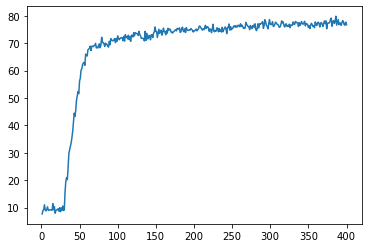

In [8]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [10]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/caltech101_EfficientNetb5_stn220220104201039.pkl
